#Downloading required packages


In [0]:
### Installing required packages
!pip install pyro-ppl==0.3.2
!pip install pycuda

     |████████████████████████████████| 235kB 6.9MB/s 
     |████████████████████████████████| 61kB 18.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/7f/2f/21/9f840307c05be374f101b0e4aee2db0596437fe2ade0334c2f
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built pyro-ppl opt-einsum


In [0]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pyro
from pyro.distributions import Normal, Delta
from diag_normal_mixture import MixtureOfDiagNormals
from pyro.infer import  SVI , Trace_ELBO , EmpiricalMarginal, TracePredictive
from pyro.optim import Adam
from torch.distributions import constraints
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import fileinput
import pycuda.driver as cuda
import requests
from functools import partial
cuda.init()

#Loading libraries


#Loading data

This is mostly boiler plate code, except for the boston and yacht datasets, every data is read directly from the source on github. For the case of boston and yacht datasets, we download them locally to fix some issues concerning the separator between each columns.

Each dataset call is then associated to a function.

In [0]:
### Loading data 
""" 
This is mostly boiler plate code, except the boston and yacht datasets, every data is read directly from the 
source on github. For the case of boston and yacht datasets, we download them locally to fix some issues concerning
the separator between each columns.
"""
boston_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/boston_housing.txt"
concrete_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/concrete.txt"
energy_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/energy_heating_load.txt"
kin8_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/kin8nm.txt"
naval_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/naval_compressor_decay.txt"
power_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/power.txt"
protein_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/protein.txt"
wine_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/wine.txt"
yacht_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/yacht.txt"
year_prediction_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/year_prediction_msd.txt"


def boston():
  r = requests.get(boston_url)
  with open('/content/boston.txt', 'wb') as f:  
    f.write(r.content)
  with fileinput.FileInput("boston.txt", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("   ", " "), end='')
  bos = [str(i) for i in range(14)]
  boston = pd.read_csv('boston.txt', sep="  | ",names = bos, header=None)
  print("Boston dataset - {} examples - 14 columns".format(len(boston)))
  print("Number of Nan :{}".format(boston.isna().sum().sum())) 
  return boston, 14

def concrete():
  conc = [str(i) for i in range(9)]
  concrete = pd.read_csv(concrete_url, sep=" |\t",names = conc, header=None)
  print("Concrete dataset - {} examples - 9 columns".format(len(concrete)))
  print("Number of Nan :{}".format(concrete.isna().sum().sum())) 
  return concrete, 9

def energy():  
  ener = [str(i) for i in range(9)]
  energy = pd.read_csv(energy_url, sep=" |\t",names = ener, header=None)
  print("Energy dataset - {} examples - 9 columns".format(len(energy)))
  print("Number of Nan :{}".format(energy.isna().sum().sum())) 
  return energy, 9

def kin8nm():
  kin8 = [str(i) for i in range(9)]
  kin8nm = pd.read_csv(kin8_url, sep="   |  ",names = kin8, header=None)
  print("Kin8nm dataset - {} examples - 10 columns".format(len(kin8nm)))
  print("Number of Nan :{}".format(kin8nm.isna().sum().sum())) 
  return kin8nm, 9

def naval():
  nav = [str(i) for i in range(17)]
  naval = pd.read_csv(naval_url, sep=" |\t", names = nav, header=None)
  print("Naval dataset - {} examples - 17 columns".format(len(naval)))
  print("Number of Nan :{}".format(naval.isna().sum().sum())) 
  return naval, 17

def power():
  pow = [str(i) for i in range(5)]
  power = pd.read_csv(power_url, sep=" |\t", names = pow, header=None)
  print("Power dataset - {} examples - 5 columns".format(len(power)))
  print("Number of Nan :{}".format(power.isna().sum().sum())) 
  return power, 5

def protein():
  prot = [str(i) for i in range(10)]
  protein = pd.read_csv(protein_url, sep=" |\t", names = prot, header=None)
  print("Protein dataset - {} examples - 10 columns".format(len(protein)))
  print("Number of Nan :{}".format(protein.isna().sum().sum())) 
  return protein, 10

def wine():
  w = [str(i) for i in range(12)]
  wine = pd.read_csv(wine_url, sep=" |\t", names = w, header=None)
  print("Wine dataset - {} examples - 12 columns".format(len(wine)))
  print("Number of Nan :{}".format(wine.isna().sum().sum())) 
  return wine, 12

def yacht(): 
  r = requests.get(yacht_url)
  with open('/content/yacht.txt', 'wb') as f:  
      f.write(r.content) 
  with fileinput.FileInput("yacht.txt", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("  ", " "), end='')
  ya = [str(i) for i in range(7)]        
  yacht = pd.read_csv('yacht.txt', sep=" ", names = ya, header=None)
  print("Yacht dataset - {} examples - 7 columns".format(len(yacht)))
  print("Number of Nan :{}".format(yacht.isna().sum().sum())) 
  return yacht, 7, 

def year_prediction():
  year = [str(i) for i in range(90)]
  year_prediction = pd.read_csv(year_prediction_url, sep=" ", names = year, header=None)
  print("Year_prediction_msd dataset - {} examples - 90 columns".format(len(year_prediction)))
  print("Number of Nan :{}".format(year_prediction.isna().sum().sum())) 
  return year_prediction, 90
  

Here you can select the dataset you want to load in by selecting the appropriate function. The rest of the code is going to split a training and test set, and then put the data in cuda tensors.

In [0]:
## Loading data: the interface is simple, every dataset can be load and preprocessed by calling the function
# with its name .

# 1 - Call the dataset you want, this is the only thing you need to choose
data, nb_features = yacht()


# 2 - Preprocessing stuff ...
nb_features = nb_features-1
col = str(nb_features) 
x = data.drop(col, axis=1)
y = data[col]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

x_train = np.array(x_train, dtype='float32')
y_train = np.array(y_train, dtype='float32')
x_test = np.array(x_test, dtype='float32')
y_test = np.array(y_test, dtype='float32')

x_train_tensor = torch.tensor(np.array(x_train),device = device)
y_train_tensor = torch.tensor(np.array(y_train),device = device)
x_test_tensor = torch.tensor(np.array(x_test),device = device)
y_test_tensor = torch.tensor(np.array(y_test),device = device)


Yacht dataset - 308 examples - 7 columns
Number of Nan :0


#Model Definition
We define a 3 hidden layer neural net using the Scaled Exponential Linear Unit  activation function. 

In [0]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NN, self).__init__()
        self.L1 = nn.Linear(input_dim, hidden_dim)
        self.L2 = nn.Linear(hidden_dim, hidden_dim)
        self.L3 = nn.Linear(hidden_dim, output_dim,bias=False)
    
    def forward(self,x):
        # return x.w + b
        h1 = F.elu(self.L1(x)) 
        h2 = F.elu(self.L2(h1))
        out = self.L3(h2)        
        return out
        
hidden_dim = 100     
pyro.clear_param_store()
neural_net = NN(nb_features,hidden_dim,1).cuda()   

Now we define the model and the guide for variational inference.

In [0]:
############### BAYESIAN LINEAR REGRESSION ############### 



def model(x_data, y_data, pi, sigma1, sigma2):
    # Prior distributions
    # Setting up the fixed parameter in our scaled mixture of gaussian
    pi = .5
    sigma1 = 1
    sigma2 = np.exp(-6)

    components_logits = torch.tensor([pi,1-pi], device=device)
    component_scale = torch.tensor([sigma1,sigma2], device=device)

    # 1st layer weight
    loc_features_w1 = torch.zeros(2,nb_features,device=device)
    coord_scale_w1 = torch.cat((torch.ones(1,nb_features,device=device) * sigma1,torch.ones(1,nb_features,device=device) * sigma2),0)
    scale_gaussian_w1 = MixtureOfDiagNormals(loc_features_w1, coord_scale_w1, components_logits).expand([hidden_dim]).to_event(1)  
    
#    # 1st layer bias
    loc_features_b1 = torch.zeros(2,hidden_dim,device=device)
    coord_scale_b1 = torch.cat((torch.ones(1,hidden_dim,device=device) * sigma1,torch.ones(1,hidden_dim,device=device) * sigma2),0)
    scale_gaussian_b1 = MixtureOfDiagNormals(loc_features_b1, coord_scale_b1, components_logits)  
   
    # 2nd layer weight
    loc_features_w2 = torch.zeros(2,hidden_dim,device=device) 
    coord_scale_w2 = torch.cat((torch.ones(1,hidden_dim,device=device) * sigma1,torch.ones(1,hidden_dim,device=device) * sigma2),0)
    scale_gaussian_w2 = MixtureOfDiagNormals(loc_features_w2, coord_scale_w2, components_logits).expand([hidden_dim]).to_event(1)
    
    # 2nd layer bias
    loc_features_b2 = torch.zeros(2,hidden_dim,device=device)
    coord_scale_b2 = torch.cat((torch.ones(1,hidden_dim,device=device) * sigma1,torch.ones(1,hidden_dim,device=device) * sigma2),0)
    scale_gaussian_b2 = MixtureOfDiagNormals(loc_features_b2, coord_scale_b2, components_logits)  
#
##    # 3rd layer weight
    loc_features_w3 = torch.zeros(2,hidden_dim,device=device)
    coord_scale_w3 = torch.cat((torch.ones(1,hidden_dim,device=device) * sigma1,torch.ones(1,hidden_dim,device=device) * sigma2),0)
    scale_gaussian_w3 = MixtureOfDiagNormals(loc_features_w3, coord_scale_w3, components_logits).expand([1]).to_event(1)

    priors = {'L1.weight': scale_gaussian_w1, 'L1.bias': scale_gaussian_b1,
              'L2.weight' :scale_gaussian_w2, 'L2.bias':scale_gaussian_b2,
              'L3.weight': scale_gaussian_w3}
    
    lifted_module = pyro.random_module("module", neural_net, priors)
    # sample a nn (which also samples w and b)
    lifted_reg_model = lifted_module()
    # Assigning priors to weights
    with pyro.plate("map", size=len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, 1),
                    obs=y_data)
        return prediction_mean


In [0]:

def guide(x_data, y_data):
    # Variational posterior approximation
    # Layer 1 weight
    w1_mu = pyro.param("w1_mu", torch.rand(hidden_dim, nb_features,device=device))
    w1_sigma = pyro.param("w1_sigma", torch.rand(hidden_dim,nb_features,device=device),constraint=constraints.positive)

    # Layer 1 bias
    b1_mu = pyro.param("b1_mu", torch.rand(hidden_dim,device=device))
    b1_sigma = pyro.param("b1_sigma", torch.rand(hidden_dim,device=device), constraint=constraints.positive)
    
    # Layer 2 weight
    w2_mu = pyro.param("w2_mu", torch.rand(hidden_dim,hidden_dim,device=device))
    w2_sigma = pyro.param("w2_sigma", torch.rand(hidden_dim,hidden_dim,device=device), constraint=constraints.positive)
    
    # Layer 2 bias
    b2_mu = pyro.param("b2_mu", torch.rand(hidden_dim,device=device))
    b2_sigma = pyro.param("b2_sigma", torch.rand(hidden_dim,device=device), constraint=constraints.positive)

#    # Layer 3 weight
    w3_mu = pyro.param("w3_mu", torch.rand(1, hidden_dim,device=device))
    w3_sigma = pyro.param("w3_sigma", torch.rand(1,hidden_dim,device=device), constraint=constraints.positive)
    
    # Latent variables
    w1 = Normal(w1_mu, w1_sigma).to_event(2)   
    b1 = Normal(b1_mu, b1_sigma).to_event(1)    
    w2 = Normal(w2_mu, w2_sigma).to_event(2)    
    b2 = Normal(b2_mu, b2_sigma).to_event(1)    
    w3 = Normal(w3_mu, w3_sigma).to_event(2)   
    
    params = {'L1.weight': w1, 'L1.bias': b1,
              'L2.weight' :w2, 'L2.bias':b2,
              'L3.weight': w3}
    # overloading the parameters in the module with random samples from the guide distributions
    lifted_module = pyro.random_module("module", neural_net, params)
    # sample a regressor
    return lifted_module()


#Training

In [0]:
optimizer = Adam({"lr": 0.005})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(), num_samples=100)
pyro.clear_param_store()


num_iterations = 35000
losses = []
batch_size = len(x_train_tensor)
def train(num_iterations):
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_train_tensor, y_train_tensor)
        losses.append(loss)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / batch_size))


In [0]:
train(num_iterations)

[iteration 0001] loss: 102734294.1722
[iteration 0501] loss: 542001.5828
[iteration 1001] loss: 48020.6799
[iteration 1501] loss: 3978.6735
[iteration 2001] loss: 60803.9944
[iteration 2501] loss: 1748.4143
[iteration 3001] loss: 841.4490
[iteration 3501] loss: 2601.8685
[iteration 4001] loss: 3028.1596
[iteration 4501] loss: 337.0182
[iteration 5001] loss: 327.6658


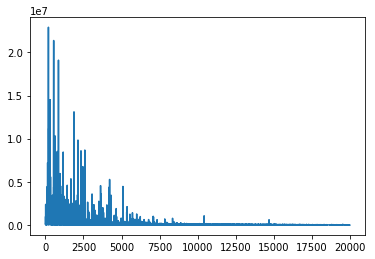

In [0]:

cost = np.array(losses[15000:])    
t = np.arange(num_iterations-15000)
plt.plot(t,cost)

In [0]:
# Utility functions
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def picp(y, y_lower, y_upper):
    batch_size = len(y)
    k = np.zeros(batch_size)
    for i in range(batch_size):
        k[i] = y_lower[i] <= y[i] <= y_upper[i]
    return np.mean(k)

def mpiw(y_lower, y_upper):
    return np.mean(y_upper-y_lower)

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))


In [0]:
# Evaluating the test set
    
posterior = svi.run(x_test_tensor, y_test_tensor)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)


post_pred_test = trace_pred.run(x_test_tensor, None)
marginal_test = get_marginal(post_pred_test, sites= ['prediction', 'obs'])
sampled_prediction_test = marginal_test[:,1]

In [0]:
## Split the evaluations
marginal_site = pd.DataFrame(sampled_prediction_test).transpose()
describe = partial(pd.Series.describe, percentiles=[.025, 0.5, 0.975])
summary = marginal_site.apply(describe, axis=1)[["mean", "std", "2.5%", "50%", "97.5%"]]

y_test_lower = np.array(summary['2.5%'])
y_test_upper = np.array(summary['97.5%'])
y_test_mean =  np.array(summary['mean'])

proba_coverage_test = picp(y_test, y_test_lower, y_test_upper)
interval_predicted_test = mpiw(y_test_lower, y_test_upper)
rmse_test = np.mean(np.sqrt(np.power((y_test_mean-y_test),2)))

interval_def = np.max(y) - np.min(y)

In [0]:
print("Yacht")
print("Prediction Interval Coverage Probability (PICP): {}".format(proba_coverage_test))
print("Mean Prediction Interval Width (MPIW): {}".format(interval_predicted_test))
print("Natural Interval Width of Data: {}".format(interval_def))
print("Root Mean Square Error (RMSE): {}".format(rmse_test))


Wine
Prediction Interval Coverage Probability (PICP): 1.0
Mean Prediction Interval Width (MPIW): 8.55914637217298
Natural Interval Width of Data: 5
Root Mean Square Error (RMSE): 0.6825891375541687
